This notebook contains the code to create two types of personalized datasets for training:



In [1]:
import sys
import pathlib
root_repo_directory = pathlib.Path().resolve().parent.__str__()
sys.path.append(root_repo_directory)
#from multilingual_chatbot_arena import initialize
import src.constants as c
import src.utils as utils
import pandas as pd
from fire import Fire
from pydantic import BaseModel
from typing import List,Optional,Dict,Union
import pathlib
import numpy as np
import pickle
from dataclasses import dataclass
import re
import requests

import os
import opik
from loguru import logger


import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoConfig,AutoModelForSequenceClassification
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from transformers.pipelines.pt_utils import KeyDataset

from sklearn.metrics import accuracy_score,confusion_matrix
from tqdm import tqdm

from collections import defaultdict
import time

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import pyarrow as pa
import pyarrow.parquet as pq

No module named 'datasets_creator'


/home/kevinmg96/miniconda3/envs/wsdm-cup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#colors
black = mcolors.CSS4_COLORS["black"]
lime = mcolors.CSS4_COLORS["lime"]
aqua = mcolors.CSS4_COLORS["aqua"]
magenta = mcolors.CSS4_COLORS["magenta"]
red = mcolors.CSS4_COLORS["red"]
grey = mcolors.CSS4_COLORS["grey"]
orange = mcolors.CSS4_COLORS["orangered"]
gold = mcolors.CSS4_COLORS["gold"]
blue = mcolors.CSS4_COLORS["blue"]
indigo = mcolors.CSS4_COLORS["indigo"]

# Loading OG challenge's dataset

In [3]:
path = root_repo_directory + c.SLASH + 'data/original'
train_df = pd.read_parquet(path + c.SLASH + "train.parquet")


In [26]:
train_df.shape

(48439, 8)

In [3]:
train_df.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a',
       'model_b', 'language'],
      dtype='object')

## New baseline dataset: dropping languages's records whose items are below or equal to 10.

In [4]:
groupby_language = train_df.groupby(["language"])

for name, group in groupby_language:
    print(f"Group: {name}")
    print(group['winner'].values)

Group: ('Abkhazian',)
['model_a']
Group: ('Afar',)
['model_a']
Group: ('Afrikaans',)
['model_a' 'model_a' 'model_a' 'model_a' 'model_b' 'model_a' 'model_a']
Group: ('Akan',)
['model_b']
Group: ('Albanian',)
['model_b' 'model_a' 'model_a']
Group: ('Amharic',)
['model_b' 'model_a' 'model_a' 'model_a' 'model_b' 'model_b']
Group: ('Arabic',)
['model_b' 'model_b' 'model_a' 'model_b' 'model_b' 'model_a' 'model_a'
 'model_a' 'model_b' 'model_a' 'model_b' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_b' 'model_a' 'model_a' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_b'
 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_b' 'model_a' 'model_b' 'model_a' 'model_a' 'model_a'
 'model_a' 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_a'
 'model_a' 'model_b' 'model_b' 'model_b' 'model_a' 'model_b' 'model_b'
 'model_a' 'model_b' 'model_b' 'model_a' 'model_b' 'model_a' 'model_a'
 'model_b' 'model_a' 

In [5]:
def func(x,**kwargs):

    if x.shape[0] > kwargs['num_group_records']:
        return x
    return 


num_group_records = 10

kwargs = {"num_group_records" : num_group_records}


train_df_baseline = groupby_language.apply(func,**kwargs).reset_index(drop=True)

/tmp/ipykernel_1533/458869094.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_baseline = groupby_language.apply(func,**kwargs).reset_index(drop=True)


In [ ]:
series_language = train_df["language"].value_counts(normalize=True)[(train_df["language"].value_counts(normalize=True) > 0.01).values]

df_series_language = pd.DataFrame({
    "languages" : series_language.keys(),
    "percentages" : series_language.values * 100 
})

In [ ]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_series_language,x="languages",y="percentages",ax=ax,color=grey)


ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Language",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Language's Percentage Distribution in Training Set",fontsize=10)

In [ ]:
train_df["language"].value_counts()[(train_df["language"].value_counts() >= 10).values]

In [ ]:
train_df["language"].value_counts()[(train_df["language"].value_counts() <= 10).values]

In [113]:
train_df["language"].value_counts()[(train_df["language"].value_counts() <= 1402).values]

language
German       1402
Japanese     1159
unknown      1128
Korean       1041
Spanish       790
             ... 
Yiddish         1
Zhuang          1
Abkhazian       1
Waray           1
Sindhi          1
Name: count, Length: 124, dtype: int64

## Detecting language for each record with unknown category

Let's use an LLM language detector to the records whose language is categorized as unknown

In [55]:
unknown_dataset = train_df_baseline.loc[train_df_baseline['language'] == "unknown"]

### Setting LanguageDecectorDataset & LanguageDetectorDataloader

In [50]:
class LanguageDetectorDataset(Dataset):
    def __init__(self,data : pd.DataFrame):
        """

        Args:
            data pd.DataFrame : data from dataset,
            comet_id Optional[str] : dataset's name id from comet ML
            prompt_id Optional[str] : prompt's template id from comet ML
        """
        self.data = data
          


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #get either a single data point or a pandas Dataframe window of data points
        data_window = self.data.iloc[idx]    

        return data_window.to_dict()

In [62]:
class LanguageDetectorDataloader(DataLoader):
    def __init__(self, tokenizer :  PreTrainedTokenizer | PreTrainedTokenizerFast, **kwargs):
        self.tokenizer = tokenizer
        
        kwargs["collate_fn"] = self.chatbot_collate
        super().__init__(**kwargs)

    
    def chatbot_collate(self,batch):
        """Custom collate function to teach the Dataloader class how to parse the batches into an llm friendly format
        Args:
            original_batch : List of batch elements with len -> batch_size. Each list's element strictly follows 
            the format inside __getitem__ from Dataset class. 
        
        """
        prompts,records_id = [],[]

        
        for dic in batch:
                
            prompts.append(dic['prompt'])
            records_id.append(dic['id'])


        #tokenize batch of prompts and answers
        prompt_tokenize = self.tokenizer(prompts,
                padding='longest',truncation=True,return_tensors="pt")

        return {
            "inputs" : prompt_tokenize, #Dict[str,torch.Tensor]
            "records_id" : records_id, #list[str]
            "longest_seq" : prompt_tokenize["input_ids"].shape[1] #int
        }

In [60]:
@torch.inference_mode()
@torch.no_grad()
def language_detection_pipeline(model,dataloader):

    data_pipeline = defaultdict(list)
    try:

        i = 0
        for i,batch in enumerate(tqdm(dataloader,desc=f"Language detection")):
            #if i < resume_idx:
            #    continue

            # Let's send current batch into model device

            inputs= batch["inputs"].to(model.device)

            logger.info(f"Batch: {i}. Max Batch Input tokens size : {inputs['input_ids'].shape[1]}")


            #forward batch of input tokens into the model, get output language ids
            logits = model(**inputs).logits

            logits = logits.detach().cpu()

            prob_dists = torch.softmax(logits, dim=-1)

            # Map raw predictions to languages
            probs, idxs = torch.max(prob_dists, dim=1)

            for language_id,record_id,prob in zip(idxs,batch['records_id'], probs):

                data_pipeline['languages'].append(model.config.id2label[language_id.item()])
                data_pipeline['records_ids'].append(record_id)
                data_pipeline['probabilities'].append(prob.item())


            #clear GPU cache
            torch.cuda.empty_cache()                
    except KeyboardInterrupt as k:
        print(k)
    except Exception as e:
        print(e)
    finally:
        return data_pipeline

### Run language detection pipeline

In [67]:


model_ckpt = "papluca/xlm-roberta-base-language-detection"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt,padding_side="left",legacy=False)
unknown_dataset_pt = LanguageDetectorDataset(unknown_dataset)
unknown_dataset_dataloader = LanguageDetectorDataloader(tokenizer,dataset =unknown_dataset_pt,batch_size=2)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,device_map="auto")
model.eval()

data_language_detection = language_detection_pipeline(model,unknown_dataset_dataloader)

Language detection:   0%|          | 0/564 [00:00<?, ?it/s]2025-02-19 08:53:05.453 | INFO     | __main__:language_detection_pipeline:17 - Batch: 0. Max Batch Input tokens size : 181
2025-02-19 08:53:05.485 | INFO     | __main__:language_detection_pipeline:17 - Batch: 1. Max Batch Input tokens size : 31
2025-02-19 08:53:05.505 | INFO     | __main__:language_detection_pipeline:17 - Batch: 2. Max Batch Input tokens size : 512
2025-02-19 08:53:05.539 | INFO     | __main__:language_detection_pipeline:17 - Batch: 3. Max Batch Input tokens size : 26
Language detection:   1%|          | 4/564 [00:00<00:14, 38.93it/s]2025-02-19 08:53:05.556 | INFO     | __main__:language_detection_pipeline:17 - Batch: 4. Max Batch Input tokens size : 95
2025-02-19 08:53:05.574 | INFO     | __main__:language_detection_pipeline:17 - Batch: 5. Max Batch Input tokens size : 422
2025-02-19 08:53:05.621 | INFO     | __main__:language_detection_pipeline:17 - Batch: 6. Max Batch Input tokens size : 165
2025-02-19 08:53

Conclusion: Let's remove the 1124 records whose language is unknown from the OG dataset

In [6]:
train_df_baseline = train_df_baseline.loc[train_df_baseline['language'] != 'unknown']

# Curated - smaller datasets

## VZ0.0

First filter: Removing records with language determined as **unknown** from OG dataset

Second filter: I'll be keeping all records from previous filter, even if language's distribution classes is not uniform.

Third filter: Ensure that output class (model_a or model_b) is uniformly distributed. If not, then remove records from filter two
until achieving this constraint.



In [121]:
train_df_baseline.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a',
       'model_b', 'language'],
      dtype='object')

In [119]:
train_df_baseline_winner_series = train_df_baseline["winner"].value_counts(normalize=True)
df_train_df_baseline_winner_series = pd.DataFrame({
    "winner" : train_df_baseline_winner_series.keys(),
    "proportion" : train_df_baseline_winner_series.values
})

Text(0.5, 1.0, "Winner Model's Proportion in Training Set")

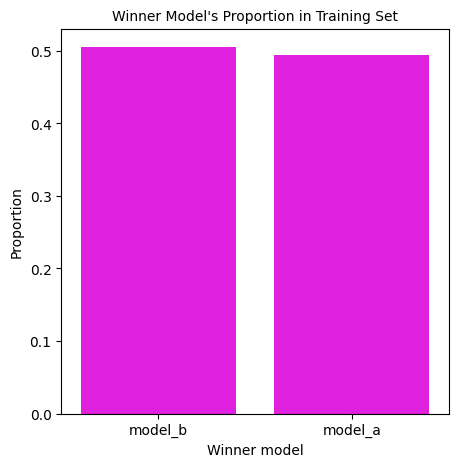

In [124]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_train_df_baseline_winner_series,x="winner",y="proportion",ax=ax,color=magenta)


#ax.tick_params(axis='x',labelrotation=90,labelsize=12)
ax.set_xlabel("Winner model",fontsize=10)
ax.set_ylabel("Proportion",fontsize=10)
ax.set_title("Winner Model's Proportion in Training Set",fontsize=10)

Distribution appears to be almost uniform.

In [6]:
curated_df_z0_0 = train_df_baseline

### Save VZ0.0 to parquet

In [139]:
table = pa.Table.from_pandas(curated_df_z0_0)

# Write Arrow Table to Parquet file
filename = "curated_small_vz0_0.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## VZ0.1

Same as dataset: ZV0.0 plus the following contraints:

filter 1: Augment data by switching response A's with response B's, of course changing the actual winner accordingly.

In [7]:
train_df_baseline_reverse = train_df_baseline.copy(deep=True)

reverse_winner = {
    "model_a" : 'model_b',
    "model_b" : "model_a"
}

In [8]:
tmp_col = train_df_baseline_reverse['response_a']

train_df_baseline_reverse['response_a'] = train_df_baseline_reverse['response_b']
train_df_baseline_reverse['response_b'] = tmp_col

train_df_baseline_reverse['winner'] = train_df_baseline_reverse['winner'].apply(lambda x : reverse_winner[x])

In [9]:
curated_df_z0_1 = pd.concat([train_df_baseline,train_df_baseline_reverse],axis=0).reset_index(drop=True)

### Save VZ0.1 to parquet

In [15]:
table = pa.Table.from_pandas(curated_df_z0_1)

# Write Arrow Table to Parquet file
filename = "curated_small_vz0_1.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## V0

Curated dataset v0 - baseline
This dataset consists of 5 (if possible) random records from each language. if not, then all the available records
will be sampled.

This baseline will be used to evaluate zero shot inference LLMs to find how well they can generalize to different
languages, I'll load their responses in comet ML, and rank them.

Results will provide a set point on fine tuning the correct (probably) LLMs.

In [6]:
def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)

    if x.shape[0] >= kwargs['num_group_records']:
        return x.iloc[:kwargs['num_group_records']]
    return x


num_group_records = 5
generator = np.random.default_rng(seed=142)
kwargs = {"num_group_records" : num_group_records, 'generator' : generator}



curated_df_v0 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

/tmp/ipykernel_87991/2821983180.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  curated_df_v0 = groupby_language.apply(func,**kwargs).reset_index(drop=True)


In [8]:
curated_df_v0.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,118c074e1e3880f61f1ecc82b392e6ba250b4cd3bb383f...,Макроэкономика,## Макроэкономика: Обзор\n\nМакроэкономика - э...,Макроэкономика — это раздел экономической наук...,model_a,gemini-1.5-pro-001,gpt-4o-2024-05-13,Abkhazian
1,49aa24778c38c727c3665dd418632176e523999397dc50...,devala maharshi,Devala Maharshi is a revered figure in Hinduis...,Devala Maharshi is a revered sage in Hindu myt...,model_a,deepseek-v2.5,qwen-plus-0828,Afar
2,5fcf043fe50553461dcd3998c4b0a0d373d404291598ee...,Wat is de betekenis van het lied aramsamsam ?,"Een interessante vraag!\n\n""Aramsamsam"" (ook w...",Ik kan geen informatie vinden over een lied ge...,model_a,llama-3.1-nemotron-70b-instruct,llama-3.1-405b-instruct-fp8,Afrikaans
3,632f631eceb574551ef09a497f77405cbf146fc2e49666...,Vertel me een goede mop,"Natuurlijk, hier is een klassieke mop voor je:...",Natuurlijk! Here is a classic Dutch joke for y...,model_a,qwen-plus-0828,deepseek-v2.5,Afrikaans
4,c35fbab864975e41640e0e384e56c57ecc0c6bb2e4254c...,wat is de populairste bezienswaardigheid van D...,De populairste bezienswaardigheid van Duitslan...,De populairste bezienswaardigheid van Duitslan...,model_a,gemini-1.5-pro-002,glm-4-plus,Afrikaans


In [7]:
curated_df_v0.shape

(467, 8)

## Save V0 to parquet

In [9]:
root: str = pathlib.Path().resolve().parent.parent.__str__()

In [9]:
root_repo_directory

'/home/kevinmg96/Kaggle competitions/WSDM Cup/multilingual-chatbot-arena/datasets_creator'

In [ ]:
train = pd.read_parquet(root + "/validation/validation_data_1.parquet")

In [ ]:
type(train)

In [ ]:
train.iloc[0]['prompt']

In [10]:
import pyarrow as pa
import pyarrow.parquet as pq
table = pa.Table.from_pandas(curated_df_v0)

# Write Arrow Table to Parquet file
filename = "curated_small_v0.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

In [11]:
curated_df_v0.shape

(467, 8)

Curated dataset v1 - Random and  uniform
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian



100 samples per language

Total samples: 2,000

Curated dataset v2 - Random and not uniform

English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean :  1,000 samples
Spanish, French, Portuguese : 500 samples
Persian, Italian, Turkish : 200 samples
Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian : 100 samples

Total samples: 8 * 1,000 + 3 * 500 + 3 * 200 + 6 * 100 = 10,700 samples

Curated dataset v3 - Random,uniform, large multilanguages
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian


100 samples per language (above)

10 samples per language (below)

Indonesian, Slovak, Swedish, Danish, Finnish, Serbian, Bulgarian, Hebrew, Thai, Romanian, Latin,Galician,
Norwegian, Catalan, Greek, Lithuanian, Croatian, Sanskrit, Estonian, Scots, Basque       66


Total samples: 20 * 100 + 21 * 10 = 2,210 samples

Curated dataset v4 - Random,not uniform, large multilanguages
Mix between v2 and v3.

respect sampling for the languages composed in V2 and include the specified samples from v3 to the remainiding 
languages. i,e. up to Hungarian is v2, and from Indonesian and so on is v3

Curated dataset v5 - Random, not uniform and English biased

Same as v2 except that English samples will be 10k

Curated dataset v6 - Random,uniform, large multilanguages

Same as v3 except that English samples will be 1k

Curated dataset v7 - Random, not uniform and English biased

Same as v2 except that English samples will be 2k

## V5

English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean :  1,000 samples
Spanish, French, Portuguese : 500 samples
Persian, Italian, Turkish : 200 samples
Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian : 100 samples

Total samples: 8 * 1,000 + 3 * 500 + 3 * 200 + 6 * 100 = 10,700 samples

In [ ]:
def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)

    main_group = ["Russian", "Chinese", "Vietnamese", "German", "Japanese",  "Korean"]
    second_group = ["Spanish", "French", "Portuguese"]
    third_group = ["Czech", "Arabic", "Polish" , "Ukrainian" , "Dutch", "Hungarian"]

    if x.name == "English":
        return x.iloc[:kwargs["english_records"]]
    elif x.name in main_group:
        return x.iloc[:1000]
    elif x.name in second_group:
        return x.iloc[:500]
    elif x.name in third_group:
        return x.iloc[:100]

    return None




In [ ]:
generator_v5 = np.random.default_rng(seed=142)
kwargs = {'generator' : generator_v5,"english_records" : 10000}



curated_df_v5 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

## Save V5 to parquet

In [ ]:

table = pa.Table.from_pandas(curated_df_v5)

# Write Arrow Table to Parquet file
filename = "curated_small_v5.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## V7

In [ ]:


generator_v7 = np.random.default_rng(seed=142)
kwargs = {'generator' : generator_v7, "english_records" : 2000}



curated_df_v7 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

## Save V7 to parquet

In [ ]:

table = pa.Table.from_pandas(curated_df_v7)

# Write Arrow Table to Parquet file
filename = "curated_small_v7.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## V8

Curated dataset v8 - Random, uniform, filter by token size

First filter: Conserve records whose prompt has less than 3.5k tokens

Second filter: 
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian

100 samples per language (if possible)

Third filter:
Ensure that output class (model_a or model_b) is uniformly distributed



In [ ]:
SYSTEM_TEMPLATE = 'You are a specialist in evaluating multilingual chat responses, with a focus on comparing and ranking outputs from different LLMs. Your primary goal is to determine which response is more likely to be preferred by humans based on factors such as clarity, relevance, tone, and overall quality.\n'
PROMPT_TEMPLATE = """Below is a prompt with two possible responses (**Response A** and **Response B**). Evaluate them, select the best one and answer in the following format (it is imperative that you respect the specified format, do not add any more text than what I ask for):\n1.- Write 'model_a' if the **Response A** is better than **Response B**, otherwise write 'model_b'.\n\n**Prompt**:\n{prompt}\n\n**Response A**:\n{response_a}\n\n**Response B**:\n{response_b}\n"""

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4"
tokenizer = AutoTokenizer.from_pretrained(
model_name,padding_side="left",legacy=False)

In [ ]:
def add_prompt_num_tokens(x,**kwargs):
    tokenizer = kwargs["tokenizer"]

    messages = [
                    {"role": "system", "content": SYSTEM_TEMPLATE},
                    {"role" : "user", "content" : PROMPT_TEMPLATE.format(
                    prompt=x.prompt,response_a=x.response_a,response_b = x.response_b)},
                    {"role" : "assistant", "content" : x.winner}
                ]
    return len(tokenizer.apply_chat_template(messages,add_generation_prompt=True,tokenize=True))

kwargs = {
    "tokenizer" :tokenizer
}
train_df["num_tokens"] = train_df.apply(add_prompt_num_tokens,axis=1,**kwargs)

train_df["num_tokens_categories"] = pd.cut(train_df["num_tokens"],10,labels=np.arange(10))

In [ ]:
num_tokens_subset =train_df.query('num_tokens_categories == 0')
group_num_tokens_subset =num_tokens_subset.groupby("language")

def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)


    group = ["English","Russian", "Chinese", "Vietnamese", "German", "Japanese",  "Korean",
                  "Spanish", "French", "Portuguese","Persian", "Italian", "Turkish",
                    "Czech", "Arabic", "Polish" , "Ukrainian" , "Dutch", "Hungarian"]


    if x.name in group:
        return x.iloc[:kwargs["num_records"]]

    return None


num_records = 100
generator = np.random.default_rng(seed=142)
kwargs = {"num_records" : num_records, 'generator' : generator}


curated_df_v8 = group_num_tokens_subset.apply(func,**kwargs).reset_index(drop=True)

Let's assess output class distribution 

In [ ]:
series_v8_winners = curated_df_v8.groupby(["winner"]).count()["id"]

df_series_v8_winners = pd.DataFrame({
    "winners" : series_v8_winners.index.values,
    "percentages" : (series_v8_winners.values / curated_df_v8.shape[0]) * 100
})

In [ ]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_series_v8_winners,x="winners",y="percentages",ax=ax,color=grey)


ax.set_xlabel("Model Winner",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Model Winner's distribution for dataset v8",fontsize=10)

Conclusion: Distribution is almost uniform, continue with the following process.

In [ ]:
curated_df_v8

### Save V8 to parquet

In [ ]:
table = pa.Table.from_pandas(curated_df_v8)

# Write Arrow Table to Parquet file
filename = "curated_small_v8.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)